**optoSTING results - Figure 4 - Prediction of c-di-GMP/IFN diffusion systems**

March 4th, 2022

*Experimental settings*

    - c-di-GMP sender (optogenetic): pIRF3_GFP, pIRF3-ISRE_mCherry
    
    - c-di-GMP receiver / IFN sender: pIRF3_H2B-mCherry-IFN
    
    - IFN receiver: ISRE_GFP
    
    - Light condition: 3h

# Imports

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io
from tqdm.notebook import tqdm
from scipy.ndimage import center_of_mass
import ipyparallel as ipp
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from matplotlib_scalebar.scalebar import ScaleBar
from skimage.measure import regionprops_table, label, regionprops
from skimage.transform import resize, downscale_local_mean, rescale
from sklearn.svm import SVC
from skimage.segmentation import find_boundaries
from ast import literal_eval
import numba as nb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, mean_squared_error, mean_squared_log_error
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import pearsonr
from plotstyle import save_fig, defaultStyle
import copy
import cv2
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
raw_img_path = lambda group: "../data/cdn_ifn_three_cell/%s/original"%group

# Utils

## Display segmentation

In [2]:
def show_seg(seg_file, img_file=None, ax=None, region=None, adjust=5, chan=0):
    # Input file is the segmentation output of *Cellpose*
    # No return. Show segmentation image
    try:
        seg_data = np.load(seg_file, allow_pickle=True).item()
        outlines = seg_data["outlines"]
    except ValueError:
        outlines = find_boundaries(np.load(seg_file))
    if img_file is None:
        img = seg_data["img"]
    else:
        img = skimage.io.imread(img_file)
    if region is None:
        region = [0, img.shape[0], 0, img.shape[1]]
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))
    im_cut = img[region[0]:region[1], region[2]:region[3]]
    outline_cut = outlines[region[0]:region[1], region[2]:region[3]]
    im_cut = im_cut / np.max(im_cut) * adjust
    im_rgb = np.zeros((im_cut.shape[0], im_cut.shape[1], 3))
    im_rgb[:, :, chan] = im_cut
    im_rgb[outline_cut > 0] = 0.8
    ax.imshow(im_rgb)
    ax.axis("off")
    
def show_seg_composite(seg_file_1, seg_file_2, ax=None, region=None, adjust_1=2, adjust_2=5):
    # Input file is the segmentation output of *Cellpose*
    # No return. Show segmentation image
    im_cut_group = []
    outline_cut_group = []
    for seg_file, adjust in zip([seg_file_1, seg_file_2], [adjust_1, adjust_2]):
        seg_data = np.load(seg_file, allow_pickle=True).item()
        outlines, img = seg_data["outlines"], seg_data["img"]
        if region is None:
            region = [0, seg_data["img"].shape[0], 0, seg_data["img"].shape[1]]
        print("Number of cells: %d"%np.max(outlines))
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(10, 10))
        im_cut = img[region[0]:region[1], region[2]:region[3]]
        outline_cut = outlines[region[0]:region[1], region[2]:region[3]]
        im_cut = im_cut / np.max(im_cut) * adjust
        im_cut_group.append(im_cut)     
        outline_cut_group.append(outline_cut)
    im_rgb = np.zeros((im_cut.shape[0], im_cut.shape[1], 3))
    im_rgb[:, :, 0] = im_cut_group[0]
    im_rgb[:, :, 1] = im_cut_group[1]
    im_rgb[:, :, 0][outline_cut_group[0] > 0] = 0.7 
    im_rgb[:, :, 1][outline_cut_group[1] > 0] = 0.7
    ax.imshow(im_rgb)
    ax.axis("off")

## Extract information from labelled image

In [2]:
def mean_intensity_of_max_n_pixels(intensity_im, n=16):
    intensity_arr = intensity_im.flatten()
    if len(intensity_arr) >= n:
        return np.mean(intensity_arr[np.argsort(intensity_arr)[-n:]])
    else:
        return np.mean(intensity_arr)
    
    
def extract_fl_loc(seg_file, img_file):
    try:
        seg_data = np.load(seg_file, allow_pickle=True).item()
        masks = seg_data["masks"]
    except ValueError:
        masks = np.load(seg_file)
    img = skimage.io.imread(img_file)
    return regionprops(masks, intensity_image=img)


def extract_fl_loc_table(seg_path):
    imageinfo_group = []
    for chan in ["red", "green"]:
        seg_file = os.path.join(seg_path, "%s.npy"%chan)
        red_img = os.path.join(raw_img_path(group), "red.tif")
        green_img = os.path.join(raw_img_path(group), "green.tif")
        props_red = extract_fl_loc(seg_file, red_img)
        props_green = extract_fl_loc(seg_file, green_img)
        imageinfo_data = np.array(
            [[
                mean_intensity_of_max_n_pixels(props_red[i].intensity_image),
                mean_intensity_of_max_n_pixels(props_green[i].intensity_image),
                props_red[i].max_intensity,
                props_green[i].max_intensity,
                props_red[i].centroid,
                props_red[i].perimeter,
                props_red[i].area,
                props_red[i].eccentricity,
                i+1
            ] for i in range(len(props_red))], dtype=object)    
        imageinfo_df = pd.DataFrame(imageinfo_data, columns=['red_fl', 'green_fl', 'max_red_fl', 'max_green_fl', 'loc', 'perimeter', 'area', 'eccentricity', 'label'])
        imageinfo_df['chan'] = chan
        imageinfo_group.append(imageinfo_df)
    imageinfo_df = pd.concat(imageinfo_group).reset_index(drop=True)
    return imageinfo_df

# Show segmented image

Number of cells: 26760
Number of cells: 14982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving figure cdn_ifn_segmentation


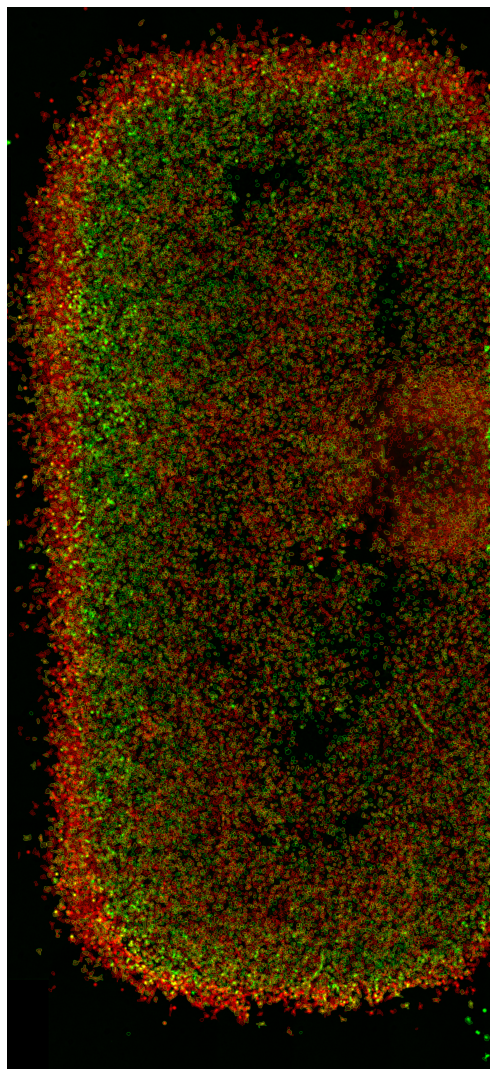

In [4]:
group = '3h'
region = None # [200, 400, 200, 400]
fs = (5, 5)
_, ax = plt.subplots(1, 1, figsize=(7, 20))
plt.subplots_adjust(hspace=0)
# show_seg(seg_file=os.path.join(seg_output_path(group), "red.npy"), ax=ax[0], region=region, adjust=1)
# show_seg(seg_file=os.path.join(seg_output_path(group), "green.npy"), ax=ax[1], region=region, chan=1, adjust=1)
show_seg_composite(
    seg_file_1=os.path.join(seg_output_path(group), "red.npy"),
    seg_file_2=os.path.join(seg_output_path(group), "green.npy") ,
    ax=ax,
    region=region
)
save_fig("cdn_ifn_segmentation")

# Extract fluorescence from red and green channel

In [5]:
%%time

group = "3h"
imageinfo_df = extract_fl_loc_table("../data/cdn_ifn_three_cell/%s/seg"%group)
scaler = MinMaxScaler((1e-1, 1))
imageinfo_df.red_fl = imageinfo_df.red_fl.apply(lambda x: np.log(np.float64(x)))
imageinfo_df.green_fl = imageinfo_df.green_fl.apply(lambda x: np.log(np.float64(x)))
scaler.fit(np.array(imageinfo_df.red_fl).reshape(-1, 1))
imageinfo_df["red_norm"] = scaler.transform(np.array(imageinfo_df.red_fl).reshape(-1, 1))
imageinfo_df["green_norm"] = scaler.transform(np.array(imageinfo_df.green_fl).reshape(-1, 1))
imageinfo_df["roundness"] = 4 * np.pi * imageinfo_df.area / (imageinfo_df.perimeter**2)
imageinfo_df.to_csv(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "imageinfo.csv"), index=False)

imageinfo_df_2 = extract_fl_loc_table("../data/cdn_ifn_three_cell/%s/seg_2"%group)
imageinfo_df_2.red_fl = imageinfo_df_2.red_fl.apply(lambda x: np.log(np.float64(x)))
imageinfo_df_2.green_fl = imageinfo_df_2.green_fl.apply(lambda x: np.log(np.float64(x)))
imageinfo_df_2["red_norm"] = scaler.transform(np.array(imageinfo_df_2.red_fl).reshape(-1, 1))
imageinfo_df_2["green_norm"] = scaler.transform(np.array(imageinfo_df_2.green_fl).reshape(-1, 1))
imageinfo_df_2["roundness"] = 4 * np.pi * imageinfo_df_2.area / (imageinfo_df_2.perimeter**2)
imageinfo_df_2.to_csv(os.path.join("../data/cdn_ifn_three_cell/%s/seg_2"%group, "imageinfo.csv"), index=False)

CPU times: user 20.1 s, sys: 676 ms, total: 20.8 s
Wall time: 20.9 s


# **Classify cells as either sender or receiver**

Use a linear SVM classifier to identify cell class

## Train SVM model with Gaussian-RBF kernel

In [6]:
%matplotlib inline

group = "3h"
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg_2"%group
imageinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "imageinfo.csv"))

X = np.array(imageinfo_df[["red_norm", "green_norm"]])
y = np.array(imageinfo_df.chan == "red", dtype=int)
clf = SVC(C=1, gamma='auto', class_weight={1: 1, 0: 6})
%time clf.fit(X, y);

CPU times: user 19.1 s, sys: 43.5 ms, total: 19.1 s
Wall time: 19.1 s


SVC(C=1, class_weight={0: 6, 1: 1}, gamma='auto')

## Show classification result on the training set

CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 13.8 s
Saving figure cdn_ifn_classify_sender_receiver


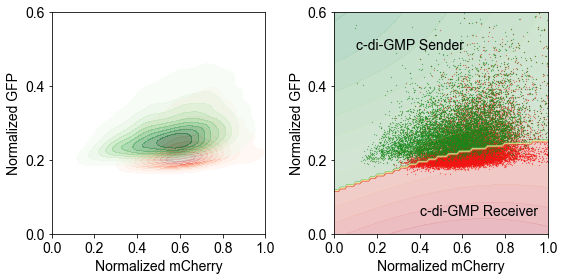

In [7]:
def plot_predictions(clf, axes, ax):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    ax.contourf(x0, x1, y_pred, cmap=plt.cm.RdYlGn_r, alpha=0.2, levels=16)
    ax.contourf(x0, x1, y_decision, cmap=plt.cm.RdYlGn_r, alpha=0.1, levels=16)

defaultStyle()
_, ax = plt.subplots(1, 2, figsize=(8, 4))
# sns.scatterplot(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="red"], color="r", s=1, ax=ax[0])
# sns.scatterplot(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="green"], color="g", s=1, ax=ax[0])
sns.kdeplot(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="red"], cmap="Reds", ax=ax[0], fill=True, alpha=0.5)
sns.kdeplot(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="green"], cmap="Greens", ax=ax[0], fill=True, alpha=0.5)

ax[1].scatter(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="red"], color="r", s=0.05)
ax[1].scatter(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="green"], color="g", s=0.05)
ax[1].text(0.1, 0.5, "c-di-GMP Sender", color="k", fontsize=14)
ax[1].text(0.4, 0.05, "c-di-GMP Receiver", color="k", fontsize=14)
for a in ax:
    a.set_xlabel("Normalized mCherry")
    a.set_ylabel("Normalized GFP")
    a.axis([0, 1, 0, 0.6])
    a.set_yticks([0, 0.2, 0.4, 0.6])

%time plot_predictions(clf, axes=[0, 1, 0, 0.7], ax=ax[1])
save_fig("cdn_ifn_classify_sender_receiver")

## Apply the SVM model to the complete dataset

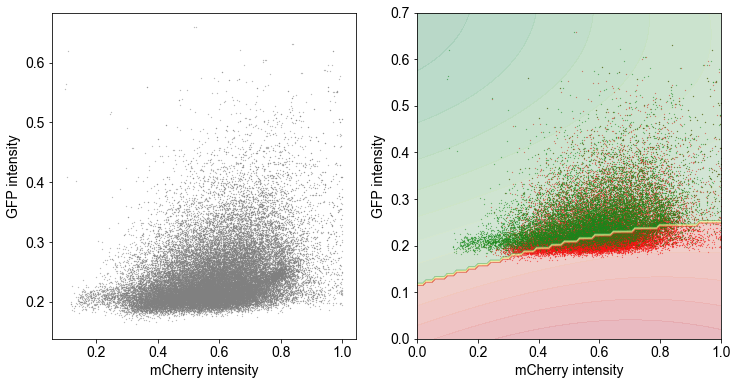

In [8]:
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
imageinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "imageinfo.csv"))
_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(x="red_norm", y="green_norm", data=imageinfo_df, color="gray", s=0.05)
ax[1].scatter(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="red"], color="r", s=0.05)
ax[1].scatter(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="green"], color="g", s=0.05)
for a in ax:
    a.set_xlabel("mCherry intensity")
    a.set_ylabel("GFP intensity")
plot_predictions(clf, axes=[0, 1, 0, 0.7], ax=ax[1])

In [9]:
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
imageinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "imageinfo.csv"))
%time imageinfo_df['cell_class'] = clf.predict(np.array(imageinfo_df[['red_norm', 'green_norm']]))
print("Green: %d"%(imageinfo_df.cell_class==0).sum())
print("Red: %d"%((imageinfo_df.cell_class==1)).sum())
imageinfo_df.to_csv(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "imageinfo.csv"), index=False)

CPU times: user 27.9 s, sys: 11.7 ms, total: 27.9 s
Wall time: 27.9 s
Green: 28415
Red: 13327


# Remove overlapping segmentation

In [10]:
group = "3h"
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
red_seg_data = np.load(os.path.join(seg_output_path(group), "red.npy"), allow_pickle=True).item()["masks"]
green_seg_data = np.load(os.path.join(seg_output_path(group), "green.npy"), allow_pickle=True).item()["masks"]
seg_data = {"red": red_seg_data, "green": green_seg_data}
sender_seg_data = np.zeros_like(red_seg_data)
receiver_seg_data = np.zeros_like(green_seg_data)
imageinfo_df = pd.read_csv(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "imageinfo.csv"))

sender_label = 1
receiver_label = 1
for i in tqdm(imageinfo_df.index):
    cell_class, chan, label = tuple(imageinfo_df.loc[i, ["cell_class", "chan", "label"]])
    if cell_class == 1:
        if (receiver_seg_data & (seg_data[chan]==label)).sum() >= (seg_data[chan]==label).sum() * 0.5:
            continue
        else:
            receiver_seg_data[seg_data[chan]==label] = receiver_label
            receiver_label += 1
    elif cell_class == 0:
        if (sender_seg_data & (seg_data[chan]==label)).sum() >= (seg_data[chan]==label).sum() * 0.5:
            continue
        else:
            sender_seg_data[seg_data[chan]==label] = sender_label
            sender_label += 1

np.save(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "sender_seg.npy"), sender_seg_data)
np.save(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "receiver_seg.npy"), receiver_seg_data)

  0%|          | 0/41742 [00:00<?, ?it/s]

Sender: 24594
Receiver: 12590
Saving figure cdn_ifn_cleaned_segmentation


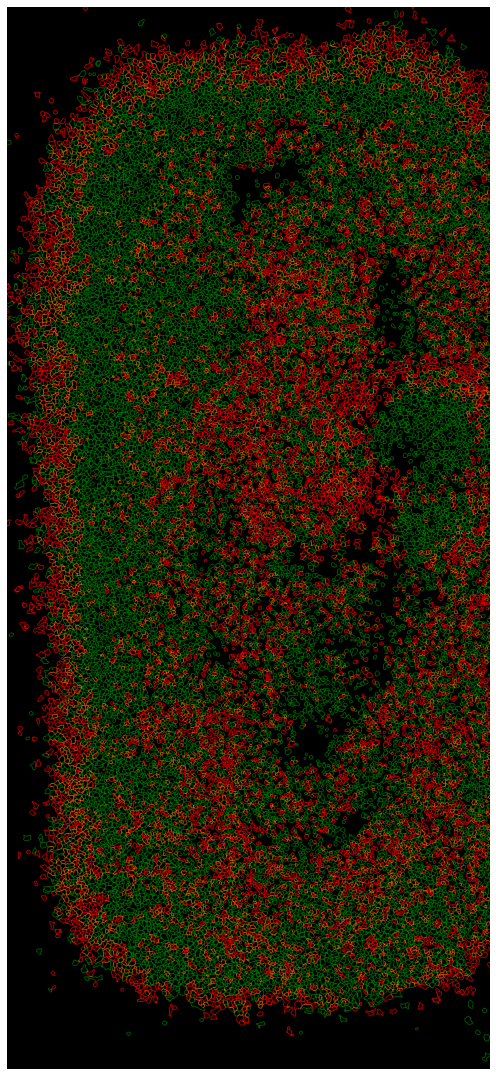

In [11]:
sender_seg_data = np.load(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "sender_seg.npy"))
receiver_seg_data = np.load(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "receiver_seg.npy"))
print("Sender: %d"%(np.max(sender_seg_data)))
print("Receiver: %d"%(np.max(receiver_seg_data)))
_, ax = plt.subplots(1, 1, figsize=(7, 20))
outline_im = np.zeros((sender_seg_data.shape[0], sender_seg_data.shape[1], 3))
outline_im[:, :, 1] = find_boundaries(sender_seg_data) * 0.5
outline_im[:, :, 0] = find_boundaries(receiver_seg_data)
ax.imshow(outline_im)
ax.axis("off")
save_fig("cdn_ifn_cleaned_segmentation")

# Re-extract fluorescence and locations of sender and receiver

In [12]:
group = "3h"
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
senderprops = extract_fl_loc(os.path.join(seg_output_path(group), "sender_seg.npy"), os.path.join(raw_img_path(group), "green.tif"))
receiverprops = extract_fl_loc(os.path.join(seg_output_path(group), "receiver_seg.npy"), os.path.join(raw_img_path(group), "red.tif"))

senderinfo = np.array(
    [[
        mean_intensity_of_max_n_pixels(senderprops[i].intensity_image, n=16),
        senderprops[i].centroid,
        i+1
    ] for i in range(len(senderprops))], dtype=object)
receiverinfo = np.array(
    [[
        mean_intensity_of_max_n_pixels(receiverprops[i].intensity_image, n=16),
        receiverprops[i].centroid,
        i+1
    ] for i in range(len(receiverprops))], dtype=object)
senderinfo_df = pd.DataFrame(senderinfo, columns=['fl', 'loc', 'label'])
senderinfo_df['cell_class'] = 'sender'
receiverinfo_df = pd.DataFrame(receiverinfo, columns=['fl', 'loc', 'label'])
receiverinfo_df['cell_class'] = 'receiver'
srinfo_df = senderinfo_df.append(receiverinfo_df, ignore_index=True).reset_index(drop=True)
srinfo_df.to_csv(os.path.join(seg_output_path(group), "srinfo.csv"), index=False)

# Determine the activation threshold

## Fluorescence distribution

In [15]:
group = "3h"
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
srinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "srinfo.csv"))
srinfo_df['log_fl'] = srinfo_df.fl.apply(np.log)

## Annotate intensity on the image

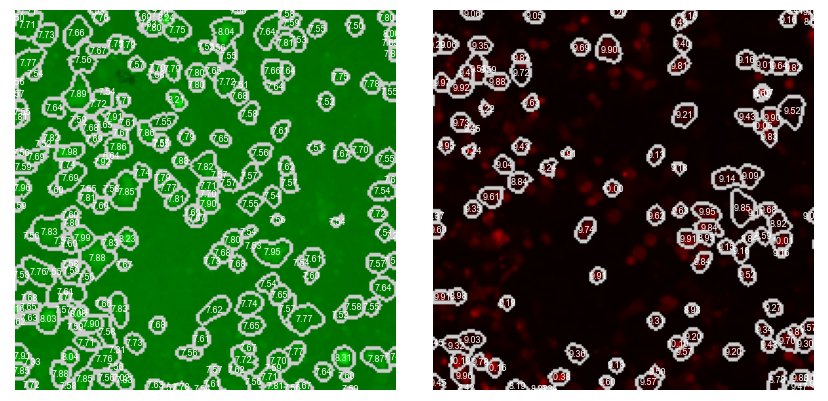

In [14]:
def show_intensity_annotation(seg_file, img_file, region, ax=None):
    try:
        masks = np.load(seg_file, allow_pickle=True).item()['masks'][region[0]:region[1], region[2]:region[3]]
    except ValueError:
        masks = np.load(seg_file)[region[0]:region[1], region[2]:region[3]]
    img = skimage.io.imread(img_file)[region[0]:region[1], region[2]:region[3]]
    props = regionprops(masks, intensity_image=img)
    for p in props:
        ax.text(
            x=p.centroid[1], 
            y=p.centroid[0], 
            s=str("%.2f"%(np.log(mean_intensity_of_max_n_pixels(p.intensity_image, 5)))),
            color="white",
            ha="center",
            va="center",
            fontsize=9
        )
        
        
group = '3h'
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
window_size = 200
startx, starty = 1500, 500
region = [startx, startx+window_size, starty, starty+window_size]
_, ax = plt.subplots(1, 2, figsize=(15, 7))
plt.subplots_adjust(wspace=0)

seg_file = os.path.join(seg_output_path(group), "sender_seg.npy")
img_file = os.path.join(raw_img_path(group), "green.tif")
show_seg(seg_file=seg_file, img_file=img_file, ax=ax[0], region=region, adjust=1, chan=1)
show_intensity_annotation(seg_file=seg_file, img_file=img_file, ax=ax[0], region=region)

seg_file = os.path.join(seg_output_path(group), "receiver_seg.npy")
img_file = os.path.join(raw_img_path(group), "red.tif")
show_seg(seg_file=seg_file, img_file=img_file, ax=ax[1], region=region, adjust=1, chan=0)
show_intensity_annotation(seg_file=seg_file, img_file=img_file, ax=ax[1], region=region)

## Activation threshold

In [16]:
sender_thresh = 7.51
receiver_thresh = 9.72

# Prediction of receiver activation based on *ReLU* model

## Calculate sender activation ratio in the neighborhood

In [5]:
def distance(loc1, loc2):
    return np.sqrt(((np.array(loc1) - np.array(loc2))**2).sum())


group = "3h"

seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
srinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "srinfo.csv"))

srinfo_df['loc'] = srinfo_df['loc'].apply(literal_eval)
srinfo_df['log_fl'] = srinfo_df.fl.apply(np.log)
srinfo_df['activation'] = ((srinfo_df.log_fl > sender_thresh) & (srinfo_df.cell_class == "sender")) | ((srinfo_df.log_fl > receiver_thresh) & (srinfo_df.cell_class == "receiver"))

print("Sender activation ratio: %.2f%%"%(100*((srinfo_df.cell_class == "sender") & (srinfo_df.log_fl > sender_thresh)).sum() / (srinfo_df.cell_class == "sender").sum()))
print("Receiver activation ratio: %.2f%%"%(100*((srinfo_df.cell_class == "receiver") & (srinfo_df.log_fl > receiver_thresh)).sum() / (srinfo_df.cell_class == "receiver").sum()))

sender_df = srinfo_df[srinfo_df.cell_class == "sender"].reset_index(drop=True)
receiver_df = srinfo_df[srinfo_df.cell_class == "receiver"].reset_index(drop=True)
receiver_df["x"] = receiver_df['loc'].apply(lambda x: x[0])
receiver_df["y"] = receiver_df['loc'].apply(lambda x: x[1])
sender_df["x"] = sender_df['loc'].apply(lambda x: x[0])
sender_df["y"] = sender_df['loc'].apply(lambda x: x[1])

cell_diameter = 12
for kernel_size in np.arange(1, 21, 2):
    neighborhood = cell_diameter * kernel_size
    for i in tqdm(receiver_df.index):
        x0 = receiver_df.loc[i, 'x']
        y0 = receiver_df.loc[i, 'y']
        neighbor_sender_df = sender_df[(sender_df.x > x0 - neighborhood) & (sender_df.x < x0 + neighborhood) & (sender_df.y > y0 - neighborhood) & (sender_df.y < y0 + neighborhood)]
        neighboring_sender_activ_arr = neighbor_sender_df[neighbor_sender_df['loc'].apply(lambda x: distance(x, [x0, y0])) <= neighborhood].activation
        nSender = len(neighboring_sender_activ_arr)
        if nSender==0:
            receiver_df.loc[i, 'fs'] = 0
        else:
            neighboring_sender_activ_ratio = neighboring_sender_activ_arr.sum() / len(neighboring_sender_activ_arr)
            receiver_df.loc[i, 'fs'] = neighboring_sender_activ_ratio
    receiver_df.to_csv("../data/cdn_ifn_three_cell/3h/results/receiver_ks_%d.csv"%kernel_size, index=False)

Sender activation ratio: 87.26%
Receiver activation ratio: 25.54%


  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

  0%|          | 0/12505 [00:00<?, ?it/s]

## Dependence of prediction accuracy on the kernel size

In [68]:
tp = 0.85

def relu(x, tp):
    return (x > tp) * 1 / (1 - tp) * (x - tp)


def linear(x, tp):
    x_half = tp + (1 - tp) / 2
    return 1 / 2 / x_half * x


def sigmoid(x, tp, n=5):
    x_half = tp + (1 - tp) / 2
    return x ** n / (x_half ** n + x ** n)

prediction_performance_df = pd.DataFrame(columns=["ks", "predfunc", "acc", "f1_macro"])
for ks in np.arange(1, 21, 2):
    receiver_df = pd.read_csv("../data/cdn_ifn_three_cell/3h/results/receiver_ks_%d.csv"%ks)
    receiver_df.dropna(inplace=True)
    receiver_df['activ_score'] = receiver_df.fs.apply(lambda x: relu(x, tp))
    receiver_df['activ_pred_stochastic'] = receiver_df.activ_score.apply(lambda x: np.random.uniform() < x)
    performance_dict = {
        "acc": accuracy_score(receiver_df.activation, receiver_df.activ_pred_stochastic),
        "f1_macro": f1_score(receiver_df.activation, receiver_df.activ_pred_stochastic, average="macro"),
        "ks": ks,
        "predfunc": "relu"
    }
    receiver_df.to_csv("../data/cdn_ifn_three_cell/3h/results/receiver_ks_%d_relu.csv"%ks, index=False)
    prediction_performance_df = prediction_performance_df.append(performance_dict, ignore_index=True)

for func in [linear, sigmoid]:
    receiver_df = pd.read_csv("../data/cdn_ifn_three_cell/3h/results/receiver_ks_5.csv")
    receiver_df.dropna(inplace=True)
    receiver_df['activ_score'] = receiver_df.fs.apply(lambda x: func(x, tp))
    receiver_df['activ_pred_stochastic'] = receiver_df.activ_score.apply(lambda x: np.random.uniform() < x)
    performance_dict = {
        "acc": accuracy_score(receiver_df.activation, receiver_df.activ_pred_stochastic),
        "f1_macro": f1_score(receiver_df.activation, receiver_df.activ_pred_stochastic, average="macro"),
        "ks": 5,
        "predfunc": f'{func}'.split(' ')[1]
    }
    receiver_df.to_csv("../data/cdn_ifn_three_cell/3h/results/receiver_ks_5_%s.csv"%(f'{func}'.split(' ')[1]), index=False)
    prediction_performance_df = prediction_performance_df.append(performance_dict, ignore_index=True)
    
prediction_performance_df.to_csv("../data/cdn_ifn_three_cell/3h/results/prediction_performance.csv", index=False)

## F1-macro vs. kernel size

Saving figure three_cell_cdn_receiver_f1_vs_ks


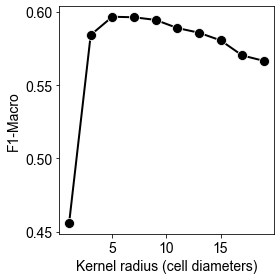

In [18]:
prediction_performance_df = pd.read_csv("../data/cdn_ifn_three_cell/3h/results/prediction_performance.csv")
defaultStyle()
_, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.lineplot(
    data=prediction_performance_df[prediction_performance_df.predfunc=="relu"],
    x="ks",
    y="f1_macro", 
    ax=ax,
    marker="o",
    markersize=10,
    linewidth=2,
    color="k"
)
ax.set_ylabel("F1-Macro")
ax.set_yticks([0.45, 0.5, 0.55, 0.6])
ax.set_xlabel("Kernel radius (cell diameters)")
# save_fig("three_cell_cdn_receiver_f1_vs_ks")

## ReLU vs. linear vs. sigmoid

Saving figure three_cell_cdn_receiver_f1_vs_predfunc


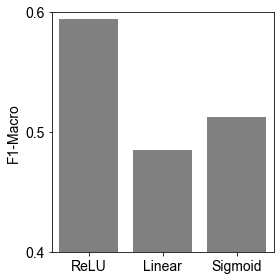

In [69]:
defaultStyle()
_, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.barplot(
    data=prediction_performance_df[prediction_performance_df.ks==5],
    x="predfunc",
    y="f1_macro", 
    ax=ax,
    color="gray"
)
ax.set_ylim([0.4, 0.6])
ax.set_ylabel("F1-Macro")
ax.set_xlabel("")
ax.set_yticks([0.4, 0.5, 0.6])
ax.set_xticklabels(["ReLU", "Linear", "Sigmoid"])
save_fig("three_cell_cdn_receiver_f1_vs_predfunc")

## Display results

Saving figure three_cell_cdn_receiver_prediction_img


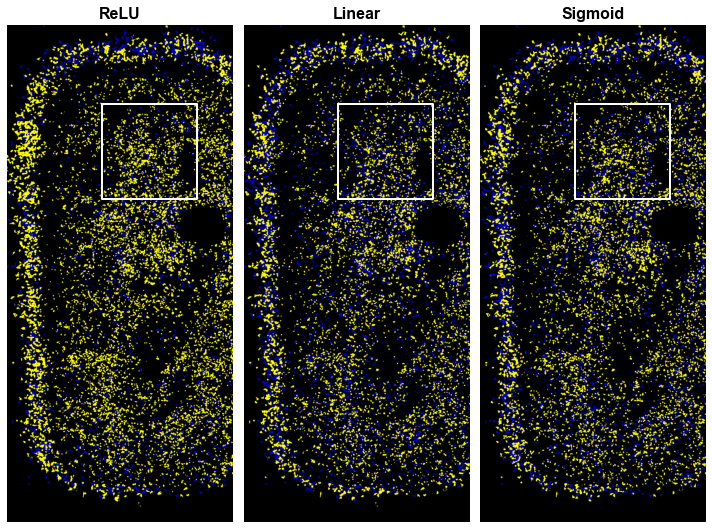

In [75]:
group = "3h"
receiver_masks = np.load(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "receiver_seg.npy"))

defaultStyle()
_, ax = plt.subplots(1, 3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.0)

x0, y0 = 500, 600
window = 600
seg_imgs = []
for i, predfunc in enumerate(["relu", "linear", "sigmoid"]):
    seg_img = np.zeros((receiver_masks.shape[0], receiver_masks.shape[1], 3))
    receiver_df = pd.read_csv("../data/cdn_ifn_three_cell/3h/results/receiver_ks_5_%s.csv"%predfunc)
    receiver_binary_masks = np.isin(receiver_masks, receiver_df[receiver_df.activation].label) * 1.0
    receiver_binary_masks += np.isin(receiver_masks, receiver_df[np.logical_not(receiver_df.activation)].label) * 0.4
    pred_receiver_binary_masks = np.isin(receiver_masks, receiver_df[receiver_df.activ_pred_stochastic].label) * 1.0
    pred_receiver_binary_masks += np.isin(receiver_masks, receiver_df[np.logical_not(receiver_df.activ_pred_stochastic)].label) * 0.4
    correct_masks = ((receiver_binary_masks==0.4) & (pred_receiver_binary_masks==0.4)) | ((receiver_binary_masks==1) & (pred_receiver_binary_masks==1))
    wrong_masks = ((receiver_binary_masks==0.4) & (pred_receiver_binary_masks==1)) | ((receiver_binary_masks==1) & (pred_receiver_binary_masks==0.4))
    # seg_img[:, :, 2] = correct_masks.astype(float)
    # seg_img[correct_masks] = 1
    seg_img[:, :, 2] = wrong_masks.astype(float) * 0.8
    seg_img[:, :, 0][correct_masks] = 1
    seg_img[:, :, 1][correct_masks] = 1
    seg_img[np.logical_not(correct_masks | wrong_masks)] = 0
    seg_imgs.append(seg_img)
    ax[i].imshow(seg_img) 
    ax[i].plot([y0, y0, y0+window, y0+window, y0], [x0, x0+window, x0+window, x0, x0], lw=2, c="w")
    ax[i].axis("off")
    ax[i].set_title(["ReLU", "Linear", "Sigmoid"][i], fontsize=16, weight="bold")
save_fig("three_cell_cdn_receiver_prediction_img")

Saving figure three_cell_cdn_receiver_prediction_img_partial


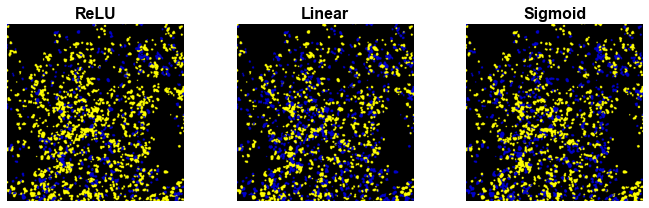

In [76]:
defaultStyle()
_, ax = plt.subplots(1, 3, figsize=(10, 3))
plt.subplots_adjust(wspace=0.02)
for i in range(3):
    seg_img = seg_imgs[i]
    ax[i].imshow(seg_img[x0:x0+window, y0:y0+window])
    ax[i].axis("off")
    ax[i].set_title(["ReLU", "Linear", "Sigmoid"][i], fontsize=16, weight="bold")
save_fig("three_cell_cdn_receiver_prediction_img_partial")

# Predicting IFN diffusion

## Downscaling masks of all cells

In [16]:
nGrid = 1200
senders = np.zeros((nGrid, nGrid)) # IFN senders
cells = np.zeros((nGrid, nGrid)) # All cells

receiver_masks = np.load("../data/cdn_ifn_three_cell/3h/seg/receiver_seg.npy")
sender_masks = np.load("../data/cdn_ifn_three_cell/3h/seg/sender_seg.npy")

# Downscaled img size
downscaled_height = receiver_masks.shape[0]//5
downscaled_width = receiver_masks.shape[1]//5

# Upper left corner
x0 = (nGrid - downscaled_height) // 2
y0 = nGrid // 2 - downscaled_width

# Shift between left and right part
xshift, yshift = 13, 0

# IFN sensing cells
ifn_receiver_masks = np.load("../data/cdn_ifn_three_cell/3h/seg/green_right_half.npy", allow_pickle=True).item()["masks"]
ifn_receiver_binary_masks = (ifn_receiver_masks > 0).astype(int)
downscaled_ifn_receivers = cv2.resize(ifn_receiver_binary_masks, (ifn_receiver_binary_masks.shape[1]//5, ifn_receiver_binary_masks.shape[0]//5), interpolation=cv2.INTER_NEAREST)


# CDN sender and receivers
receiver_binary_masks = (receiver_masks > 0).astype(int)
sender_binary_masks = (sender_masks > 0).astype(int)
downscaled_cells = cv2.resize(receiver_binary_masks, (downscaled_width, downscaled_height), interpolation=cv2.INTER_NEAREST)
downscaled_senders = cv2.resize(sender_binary_masks, (downscaled_width, downscaled_height), interpolation=cv2.INTER_NEAREST)
cells[x0:x0+downscaled_height, y0:y0+downscaled_width] = (downscaled_cells | downscaled_senders)
cells[
    (x0-xshift):(x0+downscaled_ifn_receivers.shape[0]-xshift), 
    (y0+downscaled_width-yshift):(y0+downscaled_width+downscaled_ifn_receivers.shape[1]-yshift)
] = downscaled_ifn_receivers

## Elliptic equation

$$D\left(\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2}\right) + A - \gamma u = 0$$

$$\left(u_{i,j+1}+u_{i,j-1}+u_{i+1,j}+u_{i-1,j}-4u_{i,j}\right) + h^2\cdot\dfrac{A}{D} - h^2\cdot\dfrac{\gamma}{D} u_{i,j} = 0$$

In [4]:
D = 100  # Diffusion coefficient (grid size is 6.5 um)
gamma = D / 200**2 # Consumption rate
a = 2 * np.sqrt(gamma * D)  # Synthesis rate
D /=  6.5**2
row_ind = [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + [i for i in range(1, nGrid**2) if not i % nGrid == 0] + list(range(nGrid**2-nGrid)) + list(range(nGrid, nGrid**2))
col_ind = [i for i in range(1, nGrid**2) if not i % nGrid == 0] + [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + list(range(nGrid, nGrid**2)) + list(range(nGrid**2-nGrid))
data = [-1] * (nGrid-1) * nGrid * 2 + [-1] * (nGrid**2*2 - 2*nGrid)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))
A_arr_diag_compensation = np.array(np.sum(A_arr, axis=1)).flatten()
row_ind += list(range(nGrid**2))
col_ind += list(range(nGrid**2))
data += list(np.array([4] * nGrid**2) + (gamma * cells / D).flatten() - A_arr_diag_compensation - 4)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))

result_im_raw_group = []

# Activated cdn sender cells
for predfunc in tqdm(["relu", "linear", "sigmoid"]):
    receiver_df = pd.read_csv("../data/cdn_ifn_three_cell/3h/results/receiver_ks_5_%s.csv"%predfunc)
    receiver_activ_masks = np.isin(receiver_masks, receiver_df[receiver_df.activ_pred_stochastic].label) * 1.0
    downscaled_cdn_receivers = cv2.resize(receiver_activ_masks, (downscaled_width, downscaled_height), interpolation=cv2.INTER_NEAREST)
    senders[x0:x0+downscaled_height, y0:y0+downscaled_width] = downscaled_cdn_receivers
    b = a * (senders / D).flatten()
    result_ss = spsolve(A_arr, b)
    result_im_raw_group.append(result_ss.reshape((nGrid, nGrid)))

  0%|          | 0/3 [00:00<?, ?it/s]

## IFN field

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


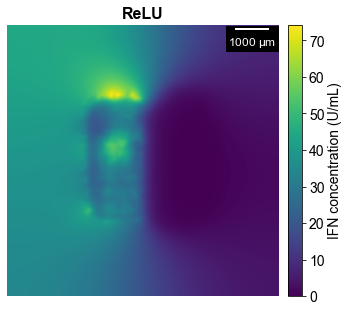

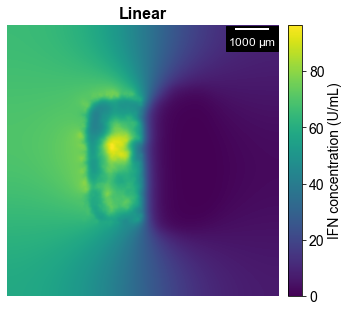

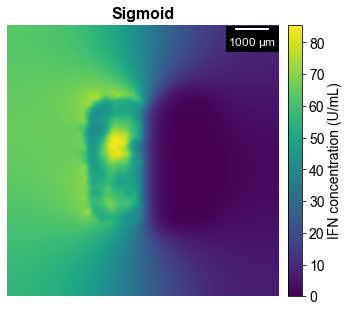

In [5]:
cmap = "viridis"
defaultStyle()

for i in range(3):
    fig = plt.figure(figsize=(15.25, 5))
    gs = GridSpec(1, 2, width_ratios=[20, 1], wspace=0.01, right=0.4)
    result_im_raw = result_im_raw_group[i]
    ax_main = fig.add_subplot(gs[0])
    ax_main.imshow(result_im_raw, cmap=cmap)
    ax_main.axis("off")
    predfunc = ["ReLU", "Linear", "Sigmoid"][i]
    ax_main.set_title(predfunc, fontsize=16, weight="bold")
    
    scalebar = ScaleBar(1.3 * 5, units="um", color="w", box_color='k', fixed_value=1000, font_properties={"size": 12, "family": "Arial"})
    ax_main.add_artist(scalebar)

    ax = fig.add_subplot(gs[1])
    norm = plt.Normalize(0, result_im_raw.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = plt.colorbar(sm, cax=ax)
    # cb.set_ticks(np.log(cbar_ticks))
    # cb.set_ticklabels(cbar_ticks)
    ax.set_ylabel("IFN concentration (U/mL)", fontsize=14)
    # save_fig("IFN_solution_%s"%(predfunc))

## Gradient comparison

        MSE  MSE_x_gradient  MSE_y_gradient  meandiff predfunc
0  0.044458        0.000267        0.001158  0.026734     ReLU
1  0.053372        0.002496        0.003377  0.089319   Linear
2  0.050670        0.001588        0.002504  0.075373  Sigmoid
Saving figure IFN_xy_gradient_prediction


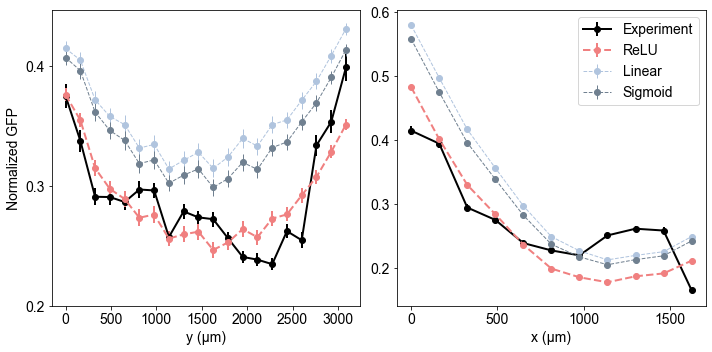

In [5]:
ifn_hill_data = np.load("../data/IFN_GFP_Hill.npy", allow_pickle=True).item()
n = ifn_hill_data["n"]
K = ifn_hill_data["K"]

downscaled_ifn_height = downscaled_ifn_receivers.shape[0]
downscaled_ifn_width = downscaled_ifn_receivers.shape[1]
ifn_receiver_im = skimage.io.imread("../data/cdn_ifn_three_cell/3h/right_half/green.tif")
ifn_receiver_masks_downscaled = cv2.resize(ifn_receiver_masks, (downscaled_ifn_width, downscaled_ifn_height), interpolation=cv2.INTER_NEAREST)
ifn_receiver_im_downscaled = resize(ifn_receiver_im, ifn_receiver_masks_downscaled.shape)
true_props = regionprops(ifn_receiver_masks_downscaled, intensity_image=ifn_receiver_im_downscaled)
true_intensity = np.array([mean_intensity_of_max_n_pixels(p.intensity_image, 10) for p in true_props])
locations_x = np.array([p.centroid[0] for p in true_props])
locations_y = np.array([p.centroid[1] for p in true_props])

percent_1, percent_2 = 100, 100
min_true_intensity = true_intensity[np.argsort(true_intensity)[len(true_intensity)//percent_2]]
max_true_intensity = true_intensity[np.argsort(true_intensity)[-len(true_intensity)//percent_1]]
true_intensity = (true_intensity - min_true_intensity) / (max_true_intensity - min_true_intensity)

crop_area_x = (locations_x > 100) & (locations_x < 600)
crop_area_y = (locations_y > 50) & (locations_y < 320)
true_intensity_x = true_intensity[crop_area_x]
true_intensity_y = true_intensity[crop_area_y]
locations_x_crop = locations_x[crop_area_x] - locations_x[crop_area_x].min()
locations_y_crop = locations_y[crop_area_y] - locations_y[crop_area_y].min()
locations_x_bins = np.arange(0, locations_x_crop.max(), 25)
locations_y_bins = np.arange(0, locations_y_crop.max(), 25)
locations_x_digit = np.digitize(locations_x_crop, locations_x_bins)
locations_y_digit = np.digitize(locations_y_crop, locations_y_bins)
true_intensity_x_binned = np.array([[np.mean(true_intensity_x[locations_x_digit==i]), np.std(true_intensity_x[locations_x_digit==i]) / np.sqrt((locations_x_digit==i).sum())] for i in range(1, locations_x_digit.max()+1)])
true_intensity_y_binned = np.array([[np.mean(true_intensity_y[locations_y_digit==i]), np.std(true_intensity_y[locations_y_digit==i]) / np.sqrt((locations_y_digit==i).sum())] for i in range(1, locations_y_digit.max()+1)])

defaultStyle()
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.15)
ax[0].errorbar(locations_x_bins * 6.5, true_intensity_x_binned[:, 0], true_intensity_x_binned[:, 1], marker="o", color="k", linewidth=2, label="Experiment")
ax[1].errorbar(locations_y_bins * 6.5, true_intensity_y_binned[:, 0], true_intensity_y_binned[:, 1], marker="o", color="k", linewidth=2, label="Experiment")

ifn_prediction_performance_df = pd.DataFrame()
for i in range(3):
    result_im_raw = result_im_raw_group[i]
    result_im = result_im_raw ** n / (K ** n + result_im_raw ** n)
    result_im_crop = result_im[
        (x0-xshift):(x0+downscaled_ifn_height-xshift), 
        (y0+downscaled_width-yshift):(y0+downscaled_width+downscaled_ifn_width-yshift)
    ]
    pred_props = regionprops(ifn_receiver_masks_downscaled, intensity_image=result_im_crop)    
    pred_intensity = np.array([mean_intensity_of_max_n_pixels(p.intensity_image, 10) for p in pred_props])
    pred_intensity_x = pred_intensity[crop_area_x]
    pred_intensity_y = pred_intensity[crop_area_y]
    pred_intensity_x_binned = np.array([[np.mean(pred_intensity_x[locations_x_digit==i]), np.std(pred_intensity_x[locations_x_digit==i]) / np.sqrt((locations_x_digit==i).sum())] for i in range(1, locations_x_digit.max()+1)])
    pred_intensity_y_binned = np.array([[np.mean(pred_intensity_y[locations_y_digit==i]), np.std(pred_intensity_y[locations_y_digit==i]) / np.sqrt((locations_y_digit==i).sum())] for i in range(1, locations_y_digit.max()+1)])
    
    lw = [2, 1, 1][i]
    color = ["lightcoral", "lightsteelblue", "slategray"][i]
    lb = ["ReLU", "Linear", "Sigmoid"][i]
    errplot_kwargs = {"marker": "o", "linewidth": lw, "linestyle": "--", "color": color, "label": lb}
    ax[0].errorbar(locations_x_bins * 6.5, pred_intensity_x_binned[:, 0], pred_intensity_x_binned[:, 1], **errplot_kwargs)
    ax[1].errorbar(locations_y_bins * 6.5, pred_intensity_y_binned[:, 0], pred_intensity_y_binned[:, 1], **errplot_kwargs)

    ifn_prediction_performance_dict = {
        "MSE": mean_squared_error(true_intensity, pred_intensity),
        "meandiff": abs(true_intensity.mean() - pred_intensity.mean()),
        "MSE_x_gradient": mean_squared_error(true_intensity_x_binned, pred_intensity_x_binned),
        "MSE_y_gradient": mean_squared_error(true_intensity_y_binned, pred_intensity_y_binned),
        "predfunc": ["ReLU", "Linear", "Sigmoid"][i]
    }
    ifn_prediction_performance_df = ifn_prediction_performance_df.append(ifn_prediction_performance_dict, ignore_index=True)
    
ax[0].set_xlabel("y (μm)")
ax[1].set_xlabel("x (μm)")
ax[0].set_yticks([0.2, 0.3, 0.4])
ax[1].set_yticks([0.2, 0.3, 0.4, 0.5, 0.6])
ax[0].set_ylabel("Normalized GFP")
ax[1].legend(loc="upper right", fontsize=14)
print(ifn_prediction_performance_df)
save_fig("IFN_xy_gradient_prediction")

## Prediction accuracy

Saving figure IFN_prediction_accuracy


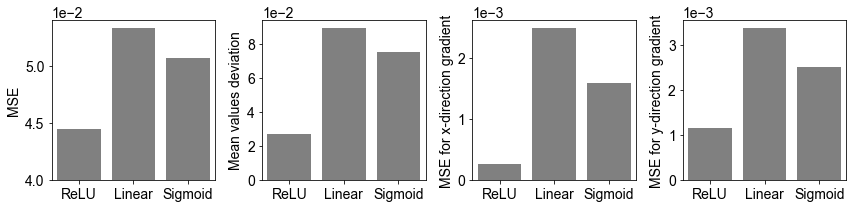

In [6]:
defaultStyle()
_, ax = plt.subplots(1, 4, figsize=(12, 3))
plt.subplots_adjust(wspace=0.35)
ylabels = ["MSE", "Mean values deviation", "MSE for x-direction gradient", "MSE for y-direction gradient"]
for i, metrics in enumerate(["MSE", "meandiff", "MSE_x_gradient", "MSE_y_gradient"]):
    sns.barplot(data=ifn_prediction_performance_df, x="predfunc", y=metrics, ax=ax[i], color="gray")
    ax[i].ticklabel_format(axis="y", style="scientific", scilimits=(0, 1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel(ylabels[i])
    if i == 0:
        ax[i].set_ylim([4e-2, 5.4e-2])
save_fig("IFN_prediction_accuracy")

## Comparison by image

In [17]:
cell_labels = np.array([p.label for p in true_props])

def label_to_intensity(label):
    if label == 0:
        return 0
    else:
        return true_intensity[cell_labels==label][0]
    
ifn_receiver_intensity_im = np.vectorize(label_to_intensity, otypes=[np.float])(ifn_receiver_masks_downscaled)

Saving figure ifn_prediction_img


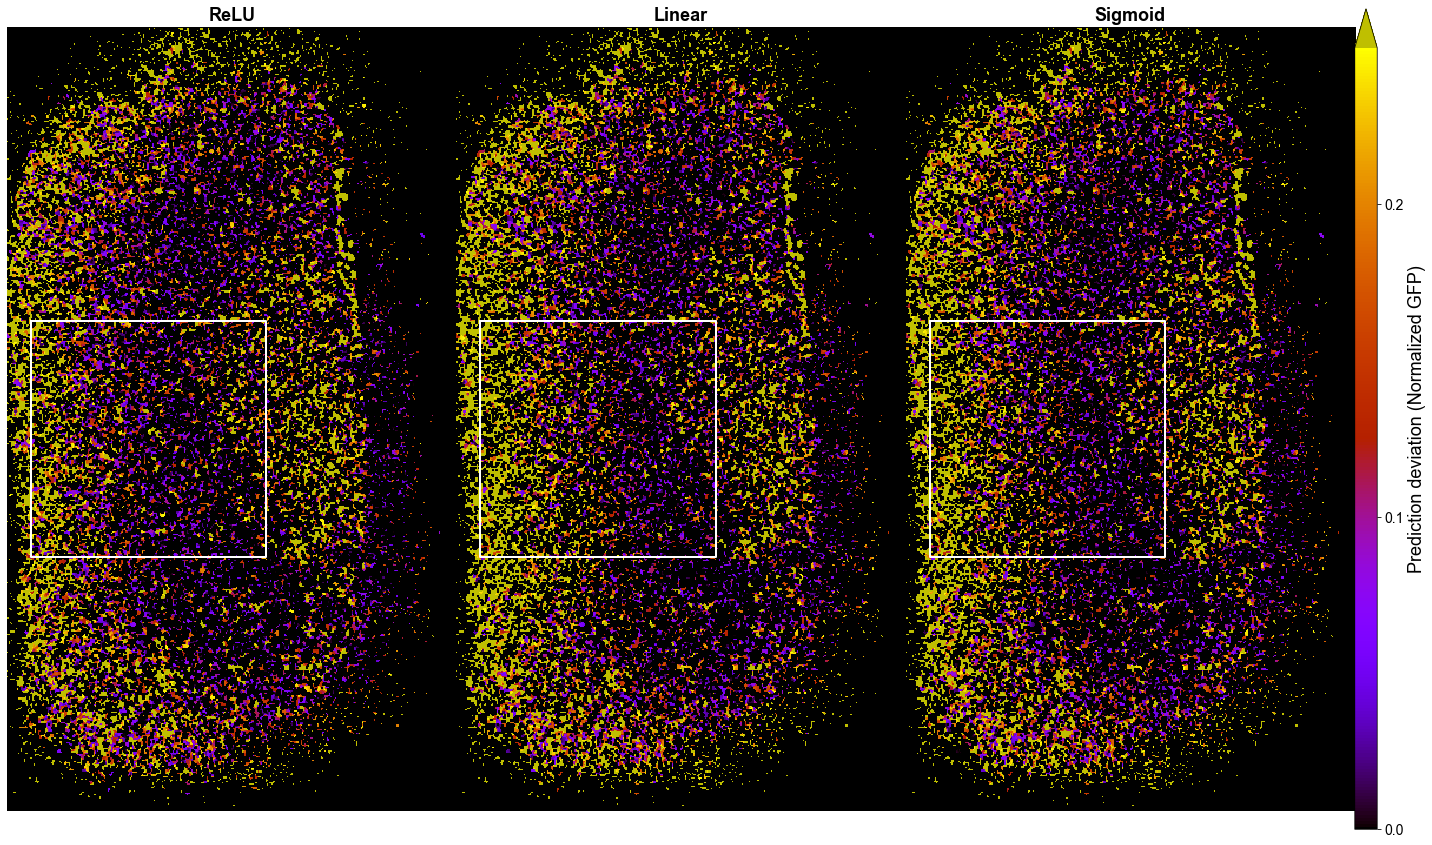

In [40]:
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(1, 4, width_ratios=[20, 20, 20, 1], wspace=0)

colMap = copy.copy(plt.get_cmap("gnuplot"))
# cbar_colors = [(0.5, 0, 1), (0, 0, 1), (0.2, 1, 1), (0.5, 1, 0.2), (0.9, 1, 0)] # first color is black, last is red
# cbar_colors = [(0, 0, 1), (0, 1, 0)]
# colMap = LinearSegmentedColormap.from_list("Custom", cbar_colors, N=1000)
colMap.set_over(color='y', alpha=1)
colMap.set_bad(color='k')

x0_window, y0_window = 250, 20
window = 200
difference_group = []
for i in range(3):
    ax = fig.add_subplot(gs[i])
    result_im_raw = result_im_raw_group[i]
    result_im = result_im_raw ** n / (K ** n + result_im_raw ** n)
    result_im_crop = result_im[
        (x0-xshift):(x0+downscaled_ifn_height-xshift), 
        (y0+downscaled_width-yshift):(y0+downscaled_width+downscaled_ifn_width-yshift)
    ]
    # ifn_receiver_im_downscaled_normalized = (ifn_receiver_im_downscaled - min_true_intensity) / (max_true_intensity - min_true_intensity)
    comparison_im_rgb = np.ones((result_im_crop.shape[0], result_im_crop.shape[1], 3))
    difference = abs(result_im_crop - ifn_receiver_intensity_im) * (ifn_receiver_masks_downscaled > 0)
    difference = np.ma.masked_where(ifn_receiver_masks_downscaled == 0, difference)
    difference_group.append(difference)
    im = ax.imshow(
        difference, cmap=colMap, norm=colors.Normalize(vmin=0, vmax=0.25))
    ax.plot([y0_window, y0_window, y0_window+window, y0_window+window, y0_window], 
            [x0_window, x0_window+window, x0_window+window, x0_window, x0_window], lw=2, c="w")
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(["ReLU", "Linear", "Sigmoid"][i], fontsize=18, weight="bold")
ax_cbar = fig.add_subplot(gs[3])
cbar = plt.colorbar(im, extend='max', shrink=0.05, cax=ax_cbar)
cbar.set_label("Prediction deviation (Normalized GFP)", fontsize=18)
cbar.set_ticks([0, 0.1, 0.2, 0.3])
save_fig("ifn_prediction_img")

Saving figure ifn_prediction_img_partial


../plotstyle.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


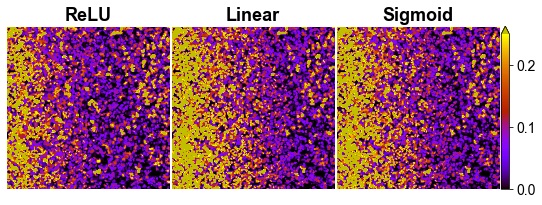

In [41]:
fig = plt.figure(figsize=(9, 3))
gs = GridSpec(1, 4, width_ratios=[20, 20, 20, 1], wspace=0.02)
for i in range(3):
    ax = fig.add_subplot(gs[i])
    difference = difference_group[i]
    im = ax.imshow(
        cv2.resize(difference[x0_window:x0_window+window, y0_window:y0_window+window], (window*3, window*3), interpolation=cv2.INTER_NEAREST), 
        cmap=colMap, norm=colors.Normalize(vmin=0, vmax=0.25)
    )
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(["ReLU", "Linear", "Sigmoid"][i], fontsize=18, weight="bold")
ax_cbar = fig.add_subplot(gs[3])
cbar = plt.colorbar(im, extend='max', shrink=0.05, cax=ax_cbar)
cbar.set_ticks([0, 0.1, 0.2, 0.3])
save_fig("ifn_prediction_img_partial")